In [1]:
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
dataPath = "C:\\Users\\KOTC\\Desktop\\1002\\Test0919_6Channel.npz"
data = np.load(dataPath)

X_data = data['X_data']
y_data = data['y_data']
i_data = data['i_data']

data.close()

print("X_data: ", X_data.shape)
print("y_data: ", y_data.shape)
print("i_data: ", i_data.shape)

X_data:  (20250, 16, 16, 6)
y_data:  (20250,)
i_data:  (20250,)


In [4]:
# Data split

# Set random seed for reproductivity
seed = 42

# Train - Test split
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_data)

# Train - Validation split
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
print(i_train.shape, i_test.shape, i_val.shape)

print(np.unique(y_train, return_counts= True))
print(np.unique(y_test, return_counts= True))
print(np.unique(y_val, return_counts= True))

(12960, 16, 16, 6) (4050, 16, 16, 6) (3240, 16, 16, 6)
(12960,) (4050,) (3240,)
(12960,) (4050,) (3240,)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
       480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
       480], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150,
       150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150,
       150], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120], dtype=int64))


In [5]:
# One - hot encoding
trainTargets = to_categorical(y_train)
testTargets = to_categorical(y_test)
valTargets = to_categorical(y_val)

print("Train targets: ", trainTargets.shape)
print("Test targets: ", testTargets.shape)
print("Validation targets: ", valTargets.shape)

Train targets:  (12960, 27)
Test targets:  (4050, 27)
Validation targets:  (3240, 27)


In [6]:
with tf.device("/device:GPU:0"):
    inputTensor = Input(shape= (16, 16, 6))

    model = MobileNetV2(input_tensor= inputTensor,
                        include_top= False,
                        weights= None,
                        pooling= 'max')

    x = model.output
    x = Dense(27, activation= 'softmax', kernel_initializer= 'he_normal')(x)

    model = Model(model.input, x)

    optim = optimizers.SGD(learning_rate= 0.01,
                           decay= 1e-3,
                           momentum= 0.9,
                           nesterov= True)

    model.compile(optimizer= optim,
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

    print("Training ===================================================")
    startTime = time.time()

    history = model.fit(X_train, trainTargets,
                        batch_size= 16,
                        epochs= 100,
                        verbose= 1,
                        validation_data= (X_val, valTargets))

    endTime = time.time()

    print(f"Training time: {np.round(endTime - startTime), 3} sec")

    model.save("C:\\Users\\KOTC\\Desktop\\1002\\Test0919_6Channel_Epoch_100.h5")

    print("Score for train dataset")
    score = model.evaluate(X_train, trainTargets, verbose= 1)
    print(f"Score: \n{model.metrics_names[0]} : {score[0]}\n{model.metrics_names[1]} : {score[1] * 100}%")

Training ===================================================
Epoch 1/100
810/810 [==============================] - 25s 22ms/step - loss: 2.6435 - accuracy: 0.2265 - val_loss: 3.5062 - val_accuracy: 0.0336
Epoch 2/100
810/810 [==============================] - 16s 20ms/step - loss: 1.6536 - accuracy: 0.4234 - val_loss: 3.6246 - val_accuracy: 0.0340
Epoch 3/100
810/810 [==============================] - 16s 19ms/step - loss: 1.2979 - accuracy: 0.5323 - val_loss: 3.6215 - val_accuracy: 0.0370
Epoch 4/100
810/810 [==============================] - 16s 19ms/step - loss: 1.1032 - accuracy: 0.5985 - val_loss: 3.5489 - val_accuracy: 0.0648
Epoch 5/100
810/810 [==============================] - 17s 21ms/step - loss: 0.9513 - accuracy: 0.6502 - val_loss: 3.2459 - val_accuracy: 0.1083
Epoch 6/100
810/810 [==============================] - 16s 20ms/step - loss: 0.8587 - accuracy: 0.6841 - val_loss: 2.7447 - val_accuracy: 0.1549
Epoch 7/100
810/810 [==============================] - 16s 20ms/step 

In [7]:
def plotHistory(history, train, validation):
    """
        plot training history
        Parameters
        ------------------------------
        history = history
        train = 'accuracy' or 'loss'
        validation = 'val_accuracy' or 'val_loss'
    """
    plt.figure(figsize= (8, 6))
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.legend(['train', 'validation'], loc= 'center right')
    plt.xlabel("Epochs")
    if train == 'accuracy':
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy for train dataset")
    elif train == "loss":
        plt.ylabel("Loss")
        plt.title("Loss for train dataset")
    plt.show()

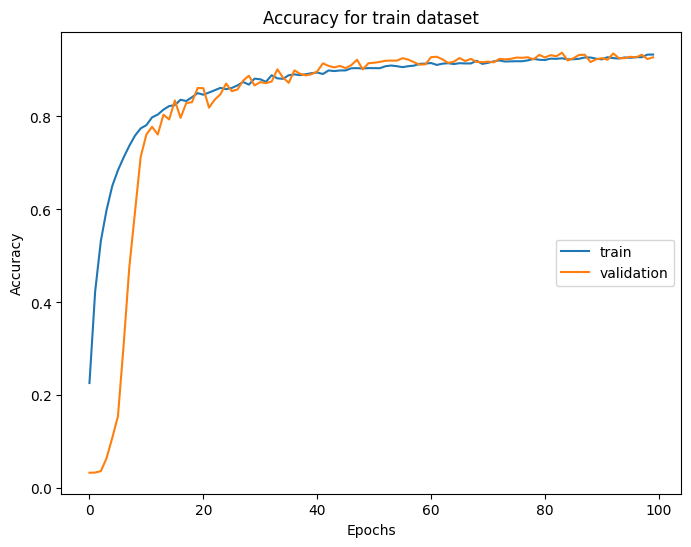

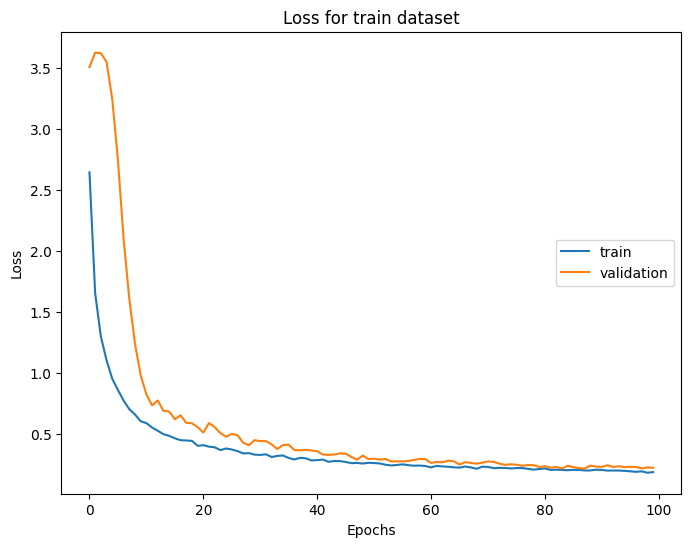

In [8]:
plotHistory(history= history, train= 'accuracy', validation= 'val_accuracy')
plotHistory(history= history, train= 'loss', validation= 'val_loss')

In [9]:
# Evaluate test dataset
testScore = model.evaluate(X_test, testTargets, verbose= 1)
print(f"{model.metrics_names[0]} : {testScore[0]}\n{model.metrics_names[1]} : {testScore[1] * 100} %")

127/127 [==============================] - 1s 10ms/step - loss: 0.2180 - accuracy: 0.9284
loss : 0.21803312003612518
accuracy : 92.83950328826904 %


127/127 [==============================] - 1s 7ms/step
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       150
           1       1.00      1.00      1.00       150
           2       0.98      0.99      0.99       150
           3       0.99      0.89      0.93       150
           4       1.00      0.99      1.00       150
           5       0.97      0.93      0.95       150
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       150
           8       0.93      0.95      0.94       150
           9       0.82      1.00      0.90       150
          10       1.00      1.00      1.00       150
          11       0.79      0.89      0.84       150
          12       1.00      0.99      1.00       150
          13       0.97      1.00      0.99       150
          14       0.83      0.42      0.56       150
          15       1.00      1.00      1.00       150
  

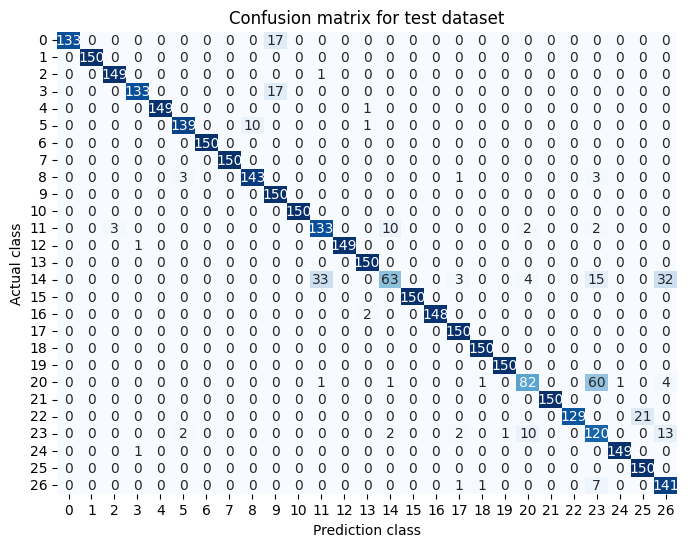

In [10]:
# Prediction for test dataset

prediction = model.predict(X_test)
predictionClass = np.argmax(prediction, axis= 1)        # One-hot encoding --> Original label

# Actual Class (One-hot encoding testTarget --> y_test)
if testTargets.ndim > 1:
    actualClass = np.argmax(testTargets, axis= 1)
else:
    actualClass = testTargets

# Classification report
print(f"Classification report: \n{classification_report(actualClass, predictionClass)}")

# Confusion matrix
plt.figure(figsize= (8, 6))
sns.heatmap(confusion_matrix(actualClass, predictionClass), 
            annot= True, 
            fmt= "d", 
            cmap= "Blues",
            cbar= False)
plt.title("Confusion matrix for test dataset")
plt.xlabel("Prediction class")
plt.ylabel("Actual class")
plt.show()

In [46]:
# Prediction for 1 image

randomImgIdx = random.randrange(0, X_test.shape[0])

predictStartTime = time.time()

predictionImg = X_test[randomImgIdx]
predictionImg = np.expand_dims(predictionImg, axis= 0)

testPrediction = model.predict(predictionImg)

predictEndTime = time.time()

print("Random image index: ", randomImgIdx)
print("Random actual label: ", i_test[randomImgIdx])
print("Random actual class: ", actualClass[randomImgIdx])
print("Random prediction class: ", predictionClass[randomImgIdx])

1/1 [==============================] - 0s 21ms/step
Random image index:  2104
Random actual label:  C12_467
Random actual class:  12
Random prediction class:  12
